In [11]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm
from statsmodels.api import OLS

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, show_summaries, get_X
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_sklearn

In [32]:
city = 'Champaign'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')

X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

(X_train, column_names) = get_X(X_train, dfb, dfu, return_columns=True)
X_test = get_X(X_test, dfb, dfu)
X_cv = get_X(X_cv, dfb, dfu)

IO(data_dir + '05_data_split.pkl').to_pickle([X_train, y_train, X_test, y_test, X_cv, y_cv])

del dfb
del dfu

In [33]:
column_names

array(['lasting', 'stars', 'ambience_divey', 'ambience_casual',
       'ambience_classy', 'ambience_hipster', 'ambience_intimate',
       'ambience_romantic', 'ambience_touristy', 'ambience_trendy',
       'ambience_upscale', 'bestnight_5', 'bestnight_1', 'bestnight_4',
       'bestnight_2', 'bestnight_3', 'bestnight_6', 'bestnight_7',
       'diary-free', 'halal', 'kosher', 'soy-free', 'vegan', 'vegetarian',
       'good_dance', 'good_kids', 'good_lunch', 'good_brunch',
       'good_dinner', 'good_latenight', 'good_group', 'background', 'dj',
       'jukebox', 'karaoke', 'live', 'video', 'accept_insurance',
       'drivu_thri', 'bike_parking', 'age_alloed', 'wifi', 'attire',
       'noise', 'fans', 'review_count', 'average_stars', 'useful', 'funny',
       'cool'], dtype=object)

In [3]:
X_subset = sm.add_constant(X_train)
ols_sm = sm.OLS(y_train, X_subset)
fit_sm = ols_sm.fit()
print(fit_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     230.0
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        16:46:09   Log-Likelihood:                -18431.
No. Observations:               12342   AIC:                         3.695e+04
Df Residuals:                   12300   BIC:                         3.726e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8821      0.069    -27.405      0.0

In [68]:
sig_vars

[0, 1, 2, 7, 21, 40, 47]

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 51


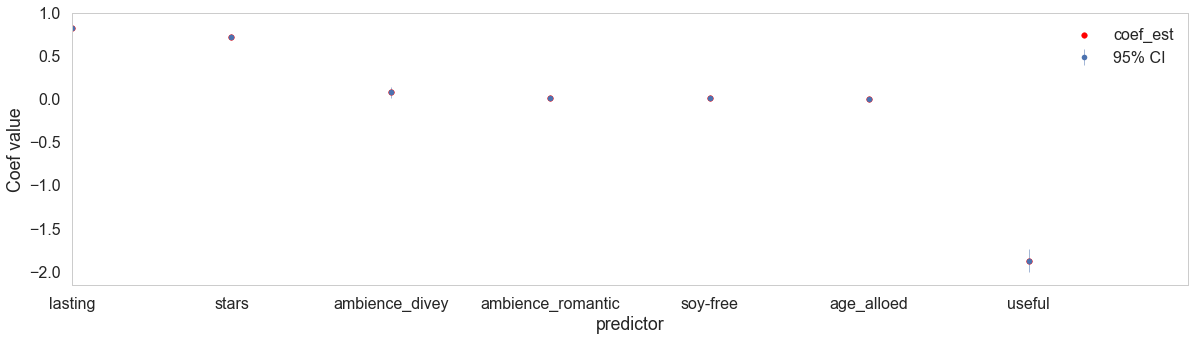

In [78]:
sig_b = []

for i in range(len(sig_vars)):
    row={}
    row["predictor"] = sig_vars[i]
    row["coef"] = fit_sm.params[sig_vars[i]]
    row["CI 2.5"] = fit_sm.conf_int()[sig_vars[i]][0]
    row["CI 97.5"] = fit_sm.conf_int()[sig_vars[i]][1]
    sig_b.append(row)

sig_b_df = pd.DataFrame(sig_b)
sig_b_df = sig_b_df.sort_values("coef", ascending=False)
sig_b_df[["predictor","coef","CI 2.5","CI 97.5"]].head()

plt.figure(figsize=(,5))

plt.errorbar(range(sig_b_df.shape[0]), 0.5*sig_b_df["CI 97.5"]+0.5*sig_b_df["CI 2.5"],  yerr=0.5*(sig_b_df["CI 97.5"]-sig_b_df["coef"])+0.5*(sig_b_df["coef"]-sig_b_df["CI 2.5"]), fmt='.', marker=None, elinewidth=0.5, label="95% CI")
plt.scatter(range(sig_b_df.shape[0]), sig_b_df["coef"], color='red', label="coef_est", marker='.') 
plt.xlim((0,sig_b_df.shape[0]))
plt.xticks(range(7), column_names[is_significant], )
plt.xlabel("predictor")
plt.ylabel("Coef value")
plt.legend()

In [65]:
is_significant = fit_sm.pvalues < 0.05
sig_vars = [i for i in range(len(is_significant)) if is_significant[i]]
print('There are {} statistically significant coefficients (p < 0.05):'.format(len(sig_vars)))


sig_vars

There are 7 statistically significant coefficients (p < 0.05):


[0, 1, 2, 7, 21, 40, 47]

In [72]:
column_names[is_significant]

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 51
  """Entry point for launching an IPython kernel.


array(['lasting', 'stars', 'ambience_divey', 'ambience_romantic',
       'soy-free', 'age_alloed', 'useful'], dtype=object)

In [12]:
es = RS_sklearn(estimator=LinearRegression()).fit(X_train, y_train)

### Linear regression

Fitting time: 0.0246 s.  
            RMSE on training set: 1.0773.  
            RMSE on test set: 1.0972.  
            $R^2$ on training set: 0.4339.   
            $R^2$ on test set: 0.4280.  
            Classification accuracy on training set: 0.3824.  
            Classification accuracy on test set: 0.3937.
            

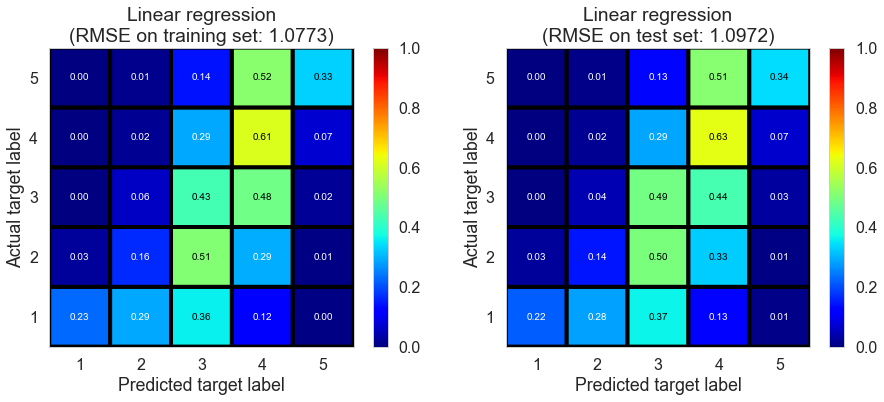

In [26]:
show_results(es, 'Linear regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

In [5]:
es = RS_sklearn(estimator=RidgeCV()).fit(X_train, y_train)

### Ridge regression

Fitting time: 0.1361 s.  
            RMSE on training set: 1.0773.  
            RMSE on test set: 1.0971.  
            $R^2$ on training set: 0.4339.   
            $R^2$ on test set: 0.4280.  
            Classification accuracy on training set: 0.3822.  
            Classification accuracy on test set: 0.3935.
            

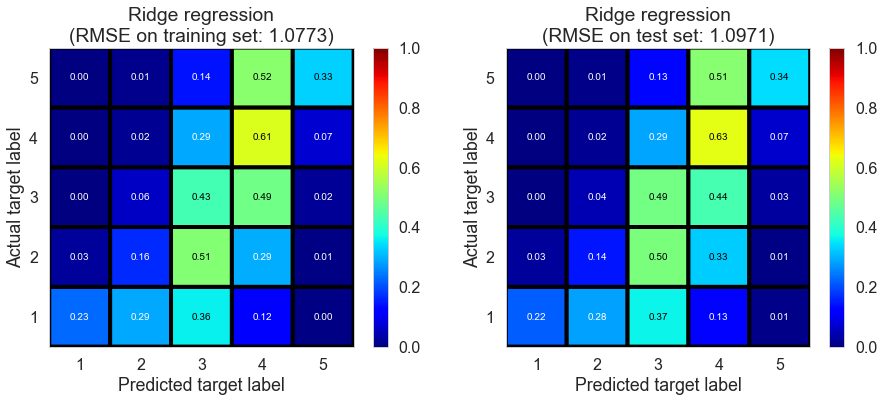

In [6]:
show_results(es, 'Ridge regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

In [7]:
es = RS_sklearn(LogisticRegressionCV(class_weight='balanced')).fit(X_train, y_train)

### Logistic regression

Fitting time: 2.6395 s.  
            RMSE on training set: 1.3972.  
            RMSE on test set: 1.4177.  
            $R^2$ on training set: 0.0479.   
            $R^2$ on test set: 0.0449.  
            Classification accuracy on training set: 0.4805.  
            Classification accuracy on test set: 0.4735.
            

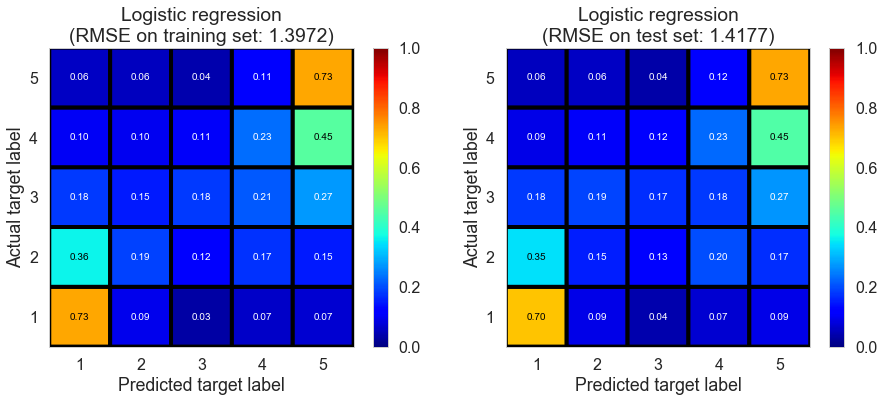

In [8]:
show_results(es, 'Logistic regression', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)

In [9]:
es = RS_sklearn(RandomForestRegressor(n_estimators=50, max_depth=7)).fit(X_train, y_train)

### Random forest regressor

Fitting time: 1.4227 s.  
            RMSE on training set: 1.0262.  
            RMSE on test set: 1.0866.  
            $R^2$ on training set: 0.4863.   
            $R^2$ on test set: 0.4389.  
            Classification accuracy on training set: 0.4163.  
            Classification accuracy on test set: 0.4119.
            

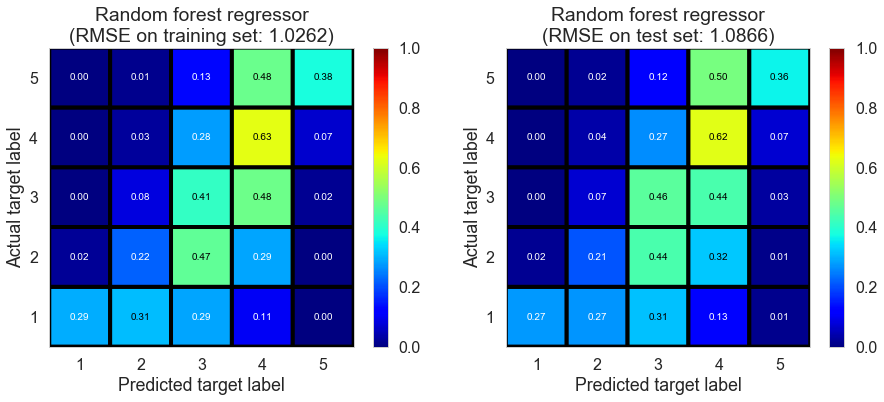

In [10]:
show_results(es, 'Random forest regressor', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
             show_cv=False)